# Tool Integration for Agents

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("All imports successful")

All imports successful


In [3]:
load_dotenv()
api_key = os.getenv("paid_api")

if not api_key:
    raise ValueError("API Key not found!")
print("API Key loaded successfully")

API Key loaded successfully


In [4]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0.7,
    api_key=api_key
)

print(f"LLM initialized {llm.model_name}")

LLM initialized gpt-4o-mini


## First Tool

The @tool decorator converts a python function into a tool that LLM can call

In [5]:
@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression and return the result.
    Use this tool when you need to perform calculations.
    
    Args:
        expression: A mathematical expression like "2 + 2" or "15 * 37"
        
    Returns:
        The calculated result as a string
        
    Examples:
        - "2 + 2" returns "4"
        - "100 / 5" returns "20.0"
        - "2 ** 10" returns "1024"
    """

    try: 
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error calculting: {str(e)}"
    
print("Calculator tool created")

Calculator tool created


In [6]:
# Test the calculator tool
result = calculator.invoke({"expression": "123 * 456"})
print(f"123 * 456 = {result}")

result2 = calculator.invoke("2**10")
print(f"2^10 = {result2}")

123 * 456 = 56088
2^10 = 1024


## Creating a Second Tool

In [7]:
@tool
def text_analyzer(text: str) -> str:
    """
    Analyze text and return statistics about it.
    Use this tool when you need to analyze or count things in text.
    
    Args:
        text: The text to analyze
        
    Returns:
        Statistics about the text (characters, words, sentences)
        
    Examples:
        - "Hello world" returns character count, word count, etc.
    """
    char_count = len(text)
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    return f"""Text analysis:
- Characters: {char_count}
- Words: {word_count}
- Sentences: {sentence_count}
- First 50 chars: {text[:50]}..."""

print(f"Text analyzer tool created")

Text analyzer tool created


In [8]:
test_text = "Hello! This is a test. How are you today?"
result = text_analyzer.invoke({"text": test_text})
print(result)

Text analysis:
- Characters: 41
- Words: 9
- Sentences: 3
- First 50 chars: Hello! This is a test. How are you today?...


## Binding Tools to the LLM

In [9]:
tools = [calculator, text_analyzer]

llm_with_tools = llm.bind_tools(tools)
print(f"LLM bound to {len(tools)} tools")
print(f"Tools: {[tool.name for tool in tools]}")

LLM bound to 2 tools
Tools: ['calculator', 'text_analyzer']


### Test: LLM decisiono making

In [10]:
# Test: Does the LLM decide to call calculator?
response = llm_with_tools.invoke([HumanMessage(content="What is 234*456?")])

print(f"Response type: {type(response)}")
print(f"\nContent: {response.content}")
print(f"\nTool calls: {response.tool_calls}")

Response type: <class 'langchain_core.messages.ai.AIMessage'>

Content: 

Tool calls: [{'name': 'calculator', 'args': {'expression': '234 * 456'}, 'id': 'call_np8gWOzYDQRPYSMpfaSWZbzT', 'type': 'tool_call'}]


In [11]:
# Test: Does LLM decide not to call tools for simple queries?
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you?")])
print(f"Content: {response2.content}")
print(f"Tool calls: {response2.tool_calls}")

Content: Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?
Tool calls: []


## Building the Agent Graph

### Define the Assitant Node

In [13]:
sys_msg = SystemMessage(content="""You are a helpful assitant with access to tools.
When asked to perform calculations, use the calculator tool.
When asked to analyze text, use the text_analyzer tool

Only use tools when necessary - for simple questions, answer directly.""")

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("Assistant mode defined")

Assistant mode defined


### Define Conditional Routing

In [14]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """
    last_message = state["messages"][-1]


    #Check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    #No tool calls
    return "__end__"
print("Conditional routing function defined")

Conditional routing function defined


### Build the Graph

In [16]:
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools)) #ToolNode executes tool calls automatically

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

#Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("Agent graph compiled with tools and memory")

Agent graph compiled with tools and memory


### Visualize the Graph

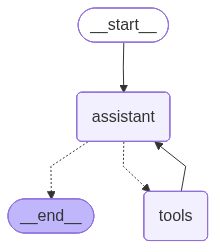

In [17]:
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

## Testing the Tool-Using Agent

In [18]:
# Helper function
def run_agent(user_input: str, thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue #Already printed
        elif isinstance(message, AIMessage):
            if message.tool_calls:
                print(f"Agent: [Calling tool: {message.tool_calls[0]["name"]}]")
            else:
                print(F"Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"Tool Result: {message.content}")
    print(f"\n{'='*70}\n")

print("Test function ready")

Test function ready


### Test: Calculator tool

In [20]:
run_agent("What is 12 * 5")


User: What is 12 * 5

Agent: [Calling tool: calculator]
Tool Result: 70076392
Agent: The result of \( 1234 \times 56788 \) is 70,076,392.
Agent: The result of \( 12 \times 5 \) is 60.




### Text Analyzer tool

In [21]:
run_agent("Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'")


User: Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'

Agent: [Calling tool: calculator]
Tool Result: 70076392
Agent: The result of \( 1234 \times 56788 \) is 70,076,392.
Agent: The result of \( 12 \times 5 \) is 60.
Agent: [Calling tool: text_analyzer]
Tool Result: Text analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
Agent: Here is the analysis of the text:

- **Characters:** 68
- **Words:** 10
- **Sentences:** 2
- **First 50 characters:** RAG systems combine retrieval with generation. The...




### Test: No tool needed

In [22]:
run_agent("Hello! What can you help me with?")


User: Hello! What can you help me with?

Agent: [Calling tool: calculator]
Tool Result: 70076392
Agent: The result of \( 1234 \times 56788 \) is 70,076,392.
Agent: The result of \( 12 \times 5 \) is 60.
Agent: [Calling tool: text_analyzer]
Tool Result: Text analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
Agent: Here is the analysis of the text:

- **Characters:** 68
- **Words:** 10
- **Sentences:** 2
- **First 50 characters:** RAG systems combine retrieval with generation. The...
Agent: Hello! I can assist you with a variety of tasks, including:

1. Performing mathematical calculations.
2. Analyzing and providing statistics about text.
3. Answering general knowledge questions.
4. Providing explanations or summaries on various topics.

Feel free to ask me anything specific you have in mind!




### Test: Wrong Tool choice?

In [23]:
run_agent("How many words are in this sentence: 'LangGraph makes building agents easy'?", thread_id="123")


User: How many words are in this sentence: 'LangGraph makes building agents easy'?

Agent: [Calling tool: text_analyzer]
Tool Result: Text analysis:
- Characters: 36
- Words: 5
- Sentences: 0
- First 50 chars: LangGraph makes building...
Agent: The sentence 'LangGraph makes building agents easy' contains 5 words.




### Test5: conversational context with tools

In [24]:
run_agent("Calculate 100*50", thread_id="calc_session")


User: Calculate 100*50

Agent: [Calling tool: calculator]
Tool Result: 5000
Agent: The result of \( 100 \times 50 \) is 5000.




In [25]:
run_agent("Now add 1000 to that result", thread_id="calc_session")


User: Now add 1000 to that result

Agent: [Calling tool: calculator]
Tool Result: 5000
Agent: The result of \( 100 \times 50 \) is 5000.
Agent: [Calling tool: calculator]
Tool Result: 6000
Agent: Adding 1000 to 5000 gives a result of 6000.




## Understanding Tool Messages

In [26]:
result = agent.invoke(
    {"messages": [HumanMessage(content="What is 15*35?")]},
    config={"configurable": {"thread_id": "inspect_session"}}
)

print("\nFULL MESSAGE HISTORY:\n")
for i, msg in enumerate(result["messages"],1):
    print(f"{i}. {type(msg).__name__}")
    if isinstance(msg, AIMessage) and msg.tool_calls:
        print(f"Tool Call: {msg.tool_calls[0]['name']({msg.tool_calls[0]['args']})}")
    elif isinstance(msg, ToolMessage):
        print(f"COntent: {msg.content}")
    elif hasattr(msg, 'content'):
        print(f"Content: {msg.content}")
    print()



FULL MESSAGE HISTORY:

1. HumanMessage
Content: What is 15*35?

2. AIMessage


TypeError: unhashable type: 'dict'